# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import random
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api

# Permet de retirer les warning message du a l'import des fichier excel.xlsx
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

# permet d'afficher toute les colonne d'un head
pd.set_option('max_columns', None)

# permet d'afficher toute les ligne d'un head
# pd.set_option('max_rows', None)

# Reset de l'affichage des colonnes et ligne
# pd.reset_option('max_columns')
pd.reset_option('max_rows')

ModuleNotFoundError: No module named 'seaborn'

# Fonction

In [3]:
# Je défini ma fonction pour check les doublons que je vais utiliser plus loin
def doublon(data):
    print(data.duplicated().sum(), 'doublons et', (~data.duplicated()).sum(), 'unique \n')

# Je crée cette fonction pour describe mes data
def check(*data):
    a = 0
    for data in data:
        a = a + 1
        # print('\\033[1m bold \\033[0m')
        print(f"\033[1m Data n°{a}: \033[0m \n\n {data.describe(include='all')}", end=' \n\n\n')

#fonction trimestre je definie des date max et mini sur none, si je les rentre pas elle sortirons la plus petite pour mini et la plus grande pour max
def trimestre(data, min_date=None, max_date=None):
    if min_date is None:
        min_date = data.year_month_day.min()
    if max_date is None:
        max_date = data.year_month_day.max()
    # je return mon data avec un filtre sur ma colonne 'YMD'
    return data[(data['year_month_day'] >= min_date) & (data['year_month_day'] <= max_date)].sort_values(by='year_month_day')

#je crée cette fonction pour afficher le chiffre d'affaires sur plusieur data
def chiffre_daffaires(*data, date1, date2):
    date1 = date1
    date2 = date2
    for i in data:
        date1 = date1 + 1
        print(f"Nombre de ligne de l'année {date1} : {len(i):,}", end='\n')
    print("\n")
    for i in data:
        date2 = date2 + 1
        print(f"Chiffre d'affaires {date2} : {round(i['price'].sum()):,}€", end='\n') # je fait la somme de mon chiffe d'affaires
    return

def courbe_lorenz(data,col):
    dep = data[col]
    n = len(dep)
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = round(2*S,2)
    print(gini)
    plt.figure(figsize=(12,8))
    xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    ident = [0, 1]
    plt.plot(ident,ident)
    plt.fill_between(np.linspace(0,1,len(lorenz)), lorenz)
    plt.text(0.2,0.8,"Gini ="+ str(gini))
    # plt.savefig('courblorenzClientPrix.png', dpi=300, transparent=True,bbox_inches='tight')
    plt.show()
    return

def cat_gender(data,sex,categ):
    f_cat_0 = data[(data['sex'] == sex) & (data['price'] > 0) & (data['categ'] == categ)]
    return len(f_cat_0)

def figS(a,b):
    plt.figure(figsize=(a,b))

var_color = ['teal','firebrick','navy','seagreen','darkmagenta','darkorange','saddlebrown','darkslategray','cadetblue','lavender','darkorchid']
# random.shuffle(var_color)

Plot style


In [4]:
plt.style.use('classic')
# plt.style.use("dark_background")
plt.rcParams.update({'text.color': 'black'})

In [3]:
# J'importe mes data néttoyé
df_final = pd.read_csv("data\Data_clean.csv")
df_final.head()

,id_prod,date,session_id,client_id,year_month_day,year_buy,Ymonth,sex,birth,price,categ
0,0_1518,2022-05-20 13:21:29,s_211425,c_103,2022-05-20,2022,2022-05,f,1986,4.18,0.0
1,1_251,2022-02-02 07:55:19,s_158752,c_8534,2022-02-02,2022,2022-02,m,1988,15.99,1.0
2,0_1277,2022-06-18 15:44:33,s_225667,c_6714,2022-06-18,2022,2022-06,f,1968,7.99,0.0
3,2_209,2021-06-24 04:19:29,s_52962,c_6941,2021-06-24,2021,2021-06,m,2000,69.99,2.0
4,0_1509,2023-01-11 08:22:08,s_325227,c_4232,2023-01-11,2023,2023-01,m,1980,4.99,0.0


In [6]:
df_final.shape

(679332, 11)

**Catégorie inconnu**

In [7]:
print('J\'ai\033[1m',len(df_final[(df_final['price'] > 0) & (df_final['categ'] == 99)]),'\033[0mproduit dans la catégorie inconnu(99) je ne prendrai pas en compte cette catégorie.')

J'ai 221 produit dans la catégorie inconnu(99) je ne prendrai pas en compte cette catégorie.


# Chiffre D'affaires
Dans un premier temps, je vais avoir besoin de différents indicateurs et graphiques autour du
chiffre d'affaires. Peux-tu également regarder l’évolution dans le temps et mettre en place une
décomposition en moyenne mobile pour évaluer la tendance globale ?

In [8]:
# Je fait le total du chiffre d'affaires
df_ca = df_final['price'].sum()
print(f'Chiffre d\'Affaires : {round(df_ca):,}€')

Chiffre d'Affaires : 11,857,586€


In [9]:
# Ici je regarde sur quelle plage sont les date (2021-03-01 a 2023-02-28)
df_final.sort_values(by='year_month_day')

,id_prod,date,session_id,client_id,year_month_day,year_buy,Ymonth,sex,birth,price,categ
367529,0_1682,2021-03-01 21:50:43,s_451,c_2187,2021-03-01,2021,2021-03,f,1981,4.22,0.0
615277,0_1115,2021-03-01 06:43:40,s_134,c_7575,2021-03-01,2021,2021-03,m,1973,6.99,0.0
301417,0_1434,2021-03-01 10:14:21,s_206,c_226,2021-03-01,2021,2021-03,m,1984,8.58,0.0
561640,2_43,2021-03-01 21:11:16,s_437,c_7563,2021-03-01,2021,2021-03,f,1999,69.99,2.0
438634,1_631,2021-03-01 05:43:45,s_127,c_8607,2021-03-01,2021,2021-03,m,1974,14.99,1.0
...,...,...,...,...,...,...,...,...,...,...,...
244231,1_283,2023-02-28 13:27:38,s_348222,c_6775,2023-02-28,2023,2023-02,m,1983,14.99,1.0
166505,0_1421,2023-02-28 12:37:59,s_348221,c_7844,2023-02-28,2023,2023-02,f,1979,19.99,0.0
250272,0_1333,2023-02-28 22:40:24,s_348416,c_6714,2023-02-28,2023,2023-02,f,1968,5.99,0.0
228119,2_12,2023-02-28 15:36:26,s_348280,c_4958,2023-02-28,2023,2023-02,m,1999,57.91,2.0


In [10]:
# Je crée une var ou j'y filtre suivant les date 2021,2022,2023
df_ca_21 = df_final[df_final['year_month_day'] <= '2021-12-31']
df_ca_22 = df_final[(df_final['year_month_day'] >= '2022-01-01') & (df_final['year_month_day'] <= '2022-12-31')]
df_ca_23 = df_final[(df_final['year_month_day'] >= '2023-01-01') & (df_final['year_month_day'] <= '2023-12-31')]

chiffre_daffaires(df_ca_21,df_ca_22,df_ca_23,date1=2020,date2=2020) # je fait la somme de mon chiffe d'affaires et de mon nombre de ligne
print(f"\nNombre de ligne total : {len(df_ca_21) + len(df_ca_22) + len(df_ca_23):,}") # je fait la somme total des rows pour etre sur de mes filtre
print(f"\nChiffre d'affaires total : {round(df_ca):,}") # je fait la somme total des rows pour etre sur de mes filtre

Nombre de ligne de l'année 2021 : 278,335
Nombre de ligne de l'année 2022 : 346,500
Nombre de ligne de l'année 2023 : 54,497


Chiffre d'affaires 2021 : 4,772,345€
Chiffre d'affaires 2022 : 6,110,776€
Chiffre d'affaires 2023 : 974,465€

Nombre de ligne total : 679,332

Chiffre d'affaires total : 11,857,586


## Histograme

### Histograme Trimestre

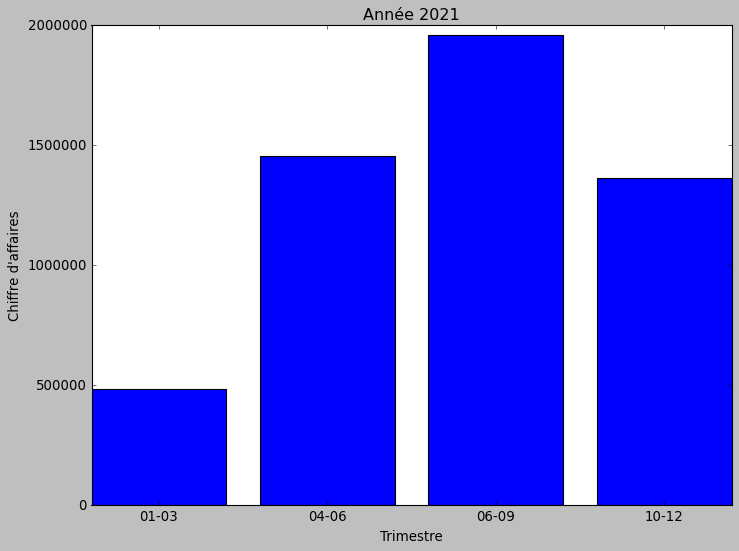

In [11]:
#je crée mes 4 variable pour les chiffre sur le trimestre
df_2021_trim1 = trimestre(df_final,min_date='2021-01-01', max_date='2021-03-31')
df_2021_trim2 = trimestre(df_final,min_date='2021-04-01', max_date='2021-06-30')
df_2021_trim3 = trimestre(df_final,min_date='2021-06-01', max_date='2021-09-31')
df_2021_trim4 = trimestre(df_final,min_date='2021-10-01', max_date='2021-12-31')

# Préparation de la figure
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# mois pour le nom de mes histo
Annees = ['01-03', '04-06', '06-09','10-12']
# valeurs pour la somme du chiffre d'affaires sur chacun de mes trimestre
valeurs = [df_2021_trim1['price'].sum(), df_2021_trim2['price'].sum(), df_2021_trim3['price'].sum(), df_2021_trim4['price'].sum()]
# Affichage des données
ax.bar(Annees, valeurs)
plt.title('Année 2021')
plt.ylabel('Chiffre d\'affaires')  # Titre de l'axe y
plt.xlabel('Trimestre')
#plt.savefig('Trimestre2021.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

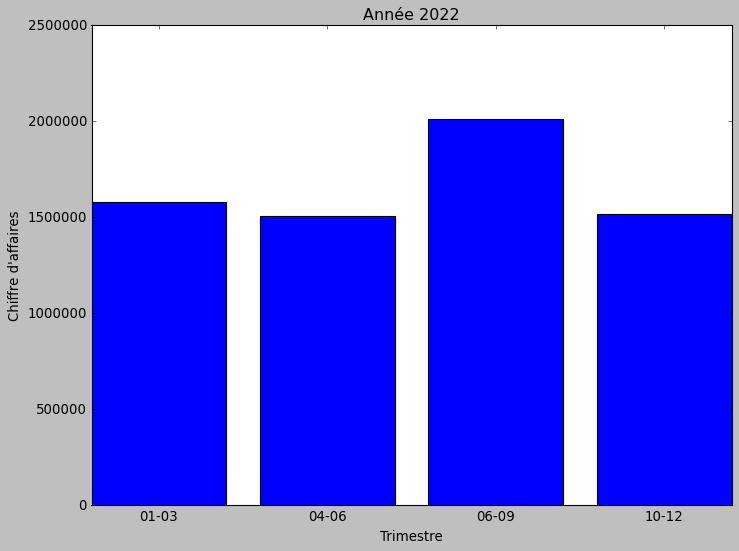

In [12]:
#je crée mes 4 variable pour les chiffre sur le trimestre
df_2022_trim1 = trimestre(df_final,min_date='2022-01-01', max_date='2022-03-31')
df_2022_trim2 = trimestre(df_final,min_date='2022-04-01', max_date='2022-06-30')
df_2022_trim3 = trimestre(df_final,min_date='2022-06-01', max_date='2022-09-31')
df_2022_trim4 = trimestre(df_final,min_date='2022-10-01', max_date='2022-12-31')

# Préparation de la figure
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# mois pour le nom de mes histo
Annees = ['01-03', '04-06', '06-09','10-12']
# valeurs pour la somme du chiffre d'affaires sur chacun de mes trimestre
valeurs = [df_2022_trim1['price'].sum(), df_2022_trim2['price'].sum(), df_2022_trim3['price'].sum(), df_2022_trim4['price'].sum()]
# Affichage des données
ax.bar(Annees, valeurs)
plt.title('Année 2022')
plt.ylabel('Chiffre d\'affaires')  # Titre de l'axe y
plt.xlabel('Trimestre')
#plt.savefig('Trimestre2022.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

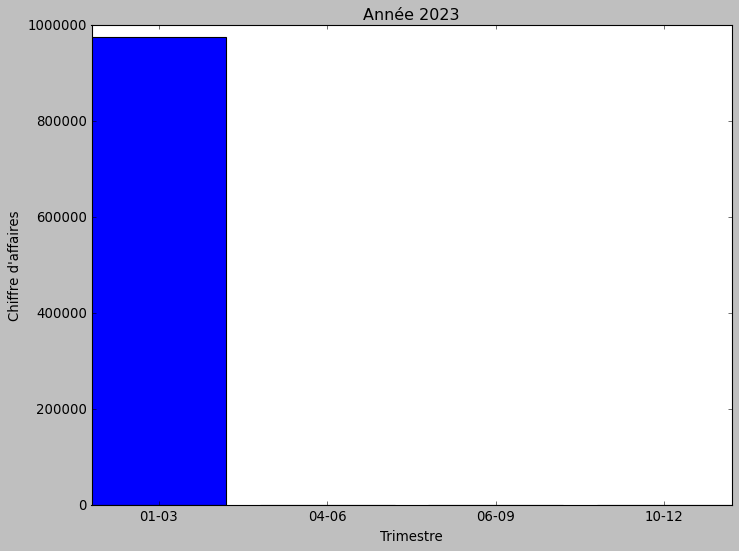

In [13]:
#je crée mes 4 variable pour les chiffre sur le trimestre
df_2023_trim1 = trimestre(df_final,min_date='2023-01-01', max_date='2023-03-31')
df_2023_trim2 = trimestre(df_final,min_date='2023-04-01', max_date='2023-06-30')
df_2023_trim3 = trimestre(df_final,min_date='2023-06-01', max_date='2023-09-31')
df_2023_trim4 = trimestre(df_final,min_date='2023-10-01', max_date='2023-12-31')

# Préparation de la figure
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# mois pour le nom de mes histo
Annees = ['01-03', '04-06', '06-09','10-12']
# valeurs pour la somme du chiffre d'affaires sur chacun de mes trimestre
valeurs = [df_2023_trim1['price'].sum(), df_2023_trim2['price'].sum(), df_2023_trim3['price'].sum(), df_2023_trim4['price'].sum()]
# Affichage des données
ax.bar(Annees, valeurs)
plt.title('Année 2023')
plt.ylabel('Chiffre d\'affaires')  # Titre de l'axe y
plt.xlabel('Trimestre')
#plt.savefig('Trimestre2023.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

### Histograme Total année

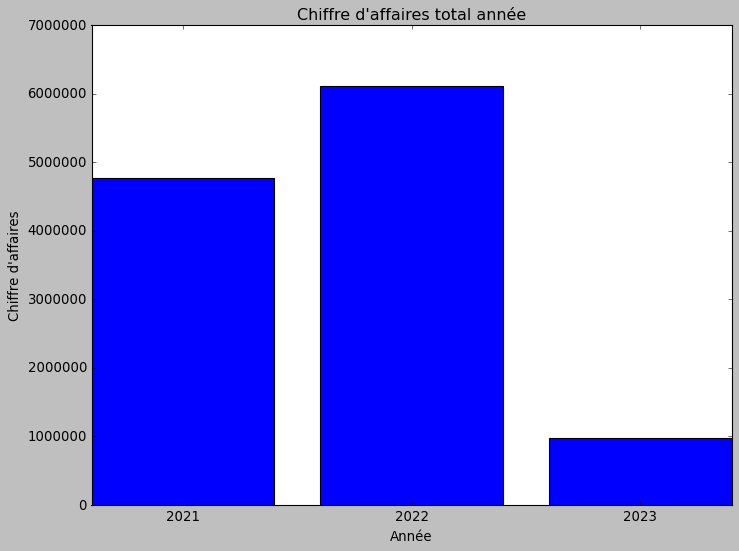

In [14]:
# Préparation de la figure
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# année pour le nom de mes histo
Annees = ['2021', '2022', '2023']
# valeurs pour la somme du chiffre d'affaires sur chacun de mes années
valeurs = [df_ca_21['price'].sum(), df_ca_22['price'].sum(), df_ca_23['price'].sum()]
# Affichage des données
ax.bar(Annees, valeurs)
plt.title('Chiffre d\'affaires total année')
plt.ylabel('Chiffre d\'affaires')  # Titre de l'axe y
plt.xlabel('Année') # Titre de l'axe x
#plt.savefig('Histoallyears.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()  # Affichage d'une courbe

### Histograme jour de la semaine

Lundi CA moyen : 18
Mardi CA moyen : 17
Mercredi CA moyen : 17
Jeudi CA moyen : 18
Vendredi CA moyen : 18
Samedi CA moyen : 17
Dimanche CA moyen : 17


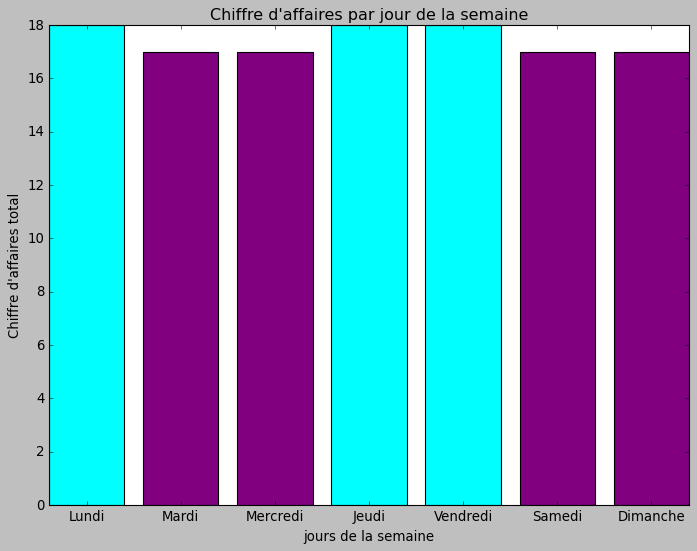

In [15]:
df_day_pl = df_final.copy()
# Je mets ma colonne au farmat date
df_day_pl['year_month_day'] = pd.to_datetime(df_final['year_month_day'])
# Je crée une colonne pour les jour de la semaine
df_day_pl['day'] = df_day_pl['year_month_day'].dt.day_name()

def dayp(data,col,day):
    return round(data[data[col] == day]['price'].mean())

print("Lundi CA moyen :",dayp(df_day_pl,'day','Monday'))
print("Mardi CA moyen :",dayp(df_day_pl,'day','Tuesday'))
print("Mercredi CA moyen :",dayp(df_day_pl,'day','Wednesday'))
print("Jeudi CA moyen :",dayp(df_day_pl,'day','Thursday'))
print("Vendredi CA moyen :",dayp(df_day_pl,'day','Friday'))
print("Samedi CA moyen :",dayp(df_day_pl,'day','Saturday'))
print("Dimanche CA moyen :",dayp(df_day_pl,'day','Sunday'))
# Préparation de la figure
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# jour pour le nom de mes histo
days = ['Lundi','Mardi','Mercredi','Jeudi','Vendredi', 'Samedi', 'Dimanche']
# valeurs pour la somme du chiffre d'affaires sur chacun de mes jour. loc[jour de la semaine][somme des prix].sum()
valeurs = [dayp(df_day_pl,'day','Monday'),dayp(df_day_pl,'day','Tuesday'), dayp(df_day_pl,'day','Wednesday'), dayp(df_day_pl,'day','Thursday'), dayp(df_day_pl,'day','Friday'), dayp(df_day_pl,'day','Saturday'), dayp(df_day_pl,'day','Sunday')]
# Affichage des données
colors = ['cyan','purple','purple','cyan','cyan','purple','purple']
ax.bar(days, valeurs, color=colors)
plt.title('Chiffre d\'affaires par jour de la semaine')
plt.ylabel('Chiffre d\'affaires total')  # Titre de l'axe y
plt.xlabel('jours de la semaine') # Titre de l'axe x
plt.show()

## Chiffre d'affaires par genre et age

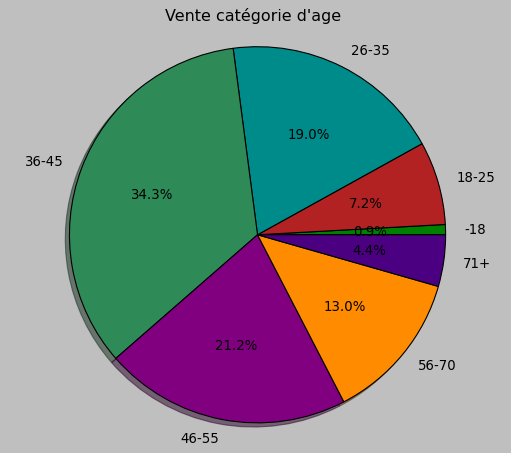

In [16]:
df_ca_und18 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] < 18)]
df_ca_18 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] >= 18) & (df_final['year_buy'] - df_final['birth'] <= 25)]
df_ca_26 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] >= 26) & (df_final['year_buy'] - df_final['birth'] <= 35)]
df_ca_36 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] >= 36) & (df_final['year_buy'] - df_final['birth'] <= 45)]
df_ca_46 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] >= 46) & (df_final['year_buy'] - df_final['birth'] <= 55)]
df_ca_56 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] >= 56) & (df_final['year_buy'] - df_final['birth'] <= 70)]
df_ca_71 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] >= 71)]

# Je crée un camembert pour afficher le % nombre de vente par vente
labels = '-18','18-25','26-35','36-45','46-55','56-70','71+'
sizes = [len(df_ca_und18) ,len(df_ca_18), len(df_ca_26), len(df_ca_36), len(df_ca_46), len(df_ca_56), len(df_ca_71)]
colors = ['green','firebrick','darkcyan','seagreen','purple','darkorange','indigo']
figS(8,6)
plt.title('Vente catégorie d\'age \n')
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
# plt.savefig('CAcategage.png', dpi=300, transparent=True)
plt.show()

In [17]:
df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] < 18)]

,id_prod,date,session_id,client_id,year_month_day,year_buy,Ymonth,sex,birth,price,categ
33,2_112,2021-07-07 22:08:01,s_59270,c_826,2021-07-07,2021,2021-07,f,2004,67.57,2.0
66,1_619,2021-05-06 02:49:42,s_30510,c_6394,2021-05-06,2021,2021-05,m,2004,12.99,1.0
493,2_55,2021-06-16 15:58:15,s_49529,c_2080,2021-06-16,2021,2021-06,m,2004,108.99,2.0
822,2_46,2021-09-19 13:59:55,s_92260,c_7971,2021-09-19,2021,2021-09,m,2004,41.31,2.0
992,1_305,2021-05-07 12:11:59,s_31145,c_5716,2021-05-07,2021,2021-05,f,2004,29.99,1.0
...,...,...,...,...,...,...,...,...,...,...,...
679237,2_62,2021-05-06 17:31:13,s_30789,c_2589,2021-05-06,2021,2021-05,f,2004,60.96,2.0
679241,2_43,2021-05-22 09:25:33,s_37904,c_5278,2021-05-22,2021,2021-05,f,2004,69.99,2.0
679271,2_101,2021-08-11 12:31:04,s_74313,c_871,2021-08-11,2021,2021-08,m,2004,63.99,2.0
679292,0_1383,2021-05-03 11:29:27,s_29291,c_3950,2021-05-03,2021,2021-05,m,2004,12.99,0.0


### Vente par genre

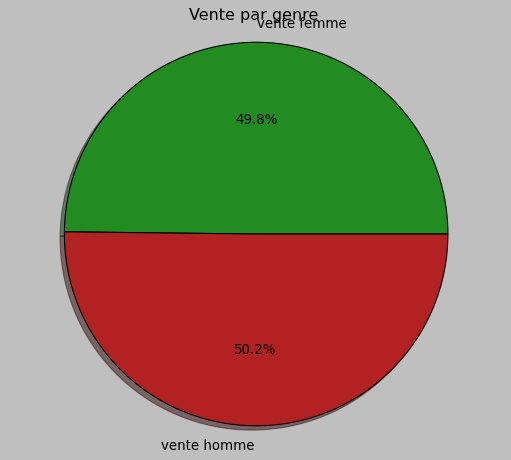

In [18]:
df_ca_f = df_final[(df_final['sex'] == 'f') & (df_final['price'] > 0)]
df_ca_m = df_final[(df_final['sex'] == 'm') & (df_final['price'] > 0)]

# Je crée un camembert pour afficher le % nombre de vente par genre
labels = 'vente femme', 'vente homme'
sizes = [len(df_ca_f), len(df_ca_m)]
colors = ['forestgreen', 'firebrick']
figS(8,6)

plt.title('Vente par genre \n')
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
# plt.savefig('VenteCateg.png', dpi=300, transparent=True)
plt.show()

### Check age 18

In [19]:
# Ici je crée un colone avec l'age
df_final['year_old'] = df_final['year_buy'] - df_final['birth']
#je filtre les 18 -
df_und_18 = df_final.loc[df_final['year_old'] <= 18]
# Je prend l'infos du prix moyen depenser par cette catégorie d'age
print('Moyenne dépense 18 :',round(df_und_18['price'].mean()))
# je check le prix max
df_und_18.sort_values(by='price', ascending=False).head()

Moyenne dépense 18 : 40


,id_prod,date,session_id,client_id,year_month_day,year_buy,Ymonth,sex,birth,price,categ,year_old
105851,2_76,2021-12-13 16:41:52,s_133825,c_665,2021-12-13,2021,2021-12,f,2004,254.44,2.0,17
103467,2_76,2022-07-12 14:52:15,s_237362,c_2791,2022-07-12,2022,2022-07,m,2004,254.44,2.0,18
598714,2_76,2022-09-12 14:52:15,s_266986,c_2791,2022-09-12,2022,2022-09,m,2004,254.44,2.0,18
641523,2_76,2021-08-12 14:52:15,s_74790,c_2791,2021-08-12,2021,2021-08,m,2004,254.44,2.0,17
72001,2_76,2022-03-12 14:52:15,s_178123,c_2791,2022-03-12,2022,2022-03,m,2004,254.44,2.0,18


In [20]:
# je regarde le meilleurs client
df_group_und_18 = df_und_18.groupby(by='client_id', sort=False)['price'].sum()
df_group_und_18.sort_values(ascending=False)

client_id
c_6977    4251.05
c_2791    3865.72
c_8159    3843.29
c_6       3803.93
c_5800    3719.36
           ...   
c_3923      34.48
c_8531      27.18
c_8527      26.23
c_8032      17.64
c_4648      11.20
Name: price, Length: 582, dtype: float64

In [21]:
# Je check les moyenne min et max
check(df_und_18.groupby(by='client_id')['price'].sum())

 Data n°1:  

 count     582.000000
mean     1075.357835
std       839.963112
min        11.200000
25%       421.145000
50%       850.795000
75%      1481.405000
max      4251.050000
Name: price, dtype: float64 




### Vente 18 ans
Sans avoir la date exact du client on va partir du principe qu'ils on 18 ans depuis x (mois/jours)

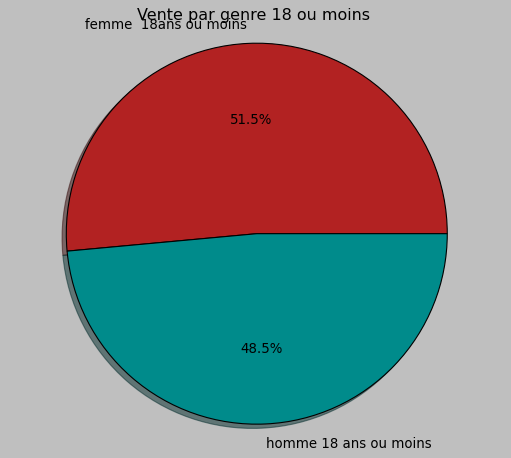

In [22]:
df_ca_f_18 = df_final[(df_final['sex'] == 'f') & (df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] <= 18)]
df_ca_m_18 = df_final[(df_final['sex'] == 'm') & (df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] <= 18)]

# Je crée un camembert pour afficher le % nombre de vente par genre 18 -
labels = 'femme  18ans ou moins','homme 18 ans ou moins',
sizes = [len(df_ca_f_18), len(df_ca_m_18)]
colors = ['firebrick','darkcyan']
# plt.style.use("dark_background")
figS(8,6)
plt.title('Vente par genre 18 ou moins \n')
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
plt.show()

### Check 18 - 20

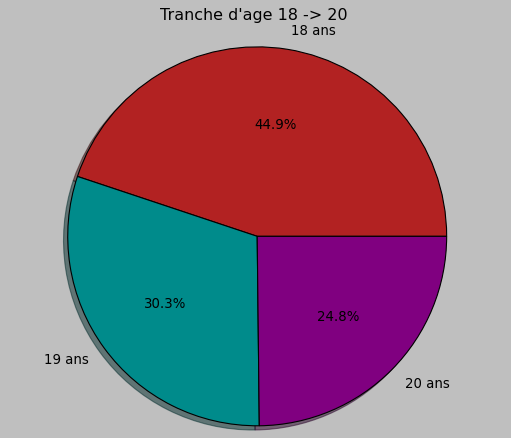

In [23]:
df_ca_18 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] == 18)]
df_ca_19 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] == 19)]
df_ca_20 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] == 20)]

# Je crée un camembert pour afficher le % nombre de vente par tranche d'age 18-20
labels = '18 ans','19 ans','20 ans',
sizes = [len(df_ca_f_18), len(df_ca_19), len(df_ca_20)]
colors = ['firebrick','darkcyan','purple']
figS(8,6)
plt.title('Tranche d\'age 18 -> 20 \n')
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
plt.show()

## Variation du prix moyen par semaine, mois, trimestre

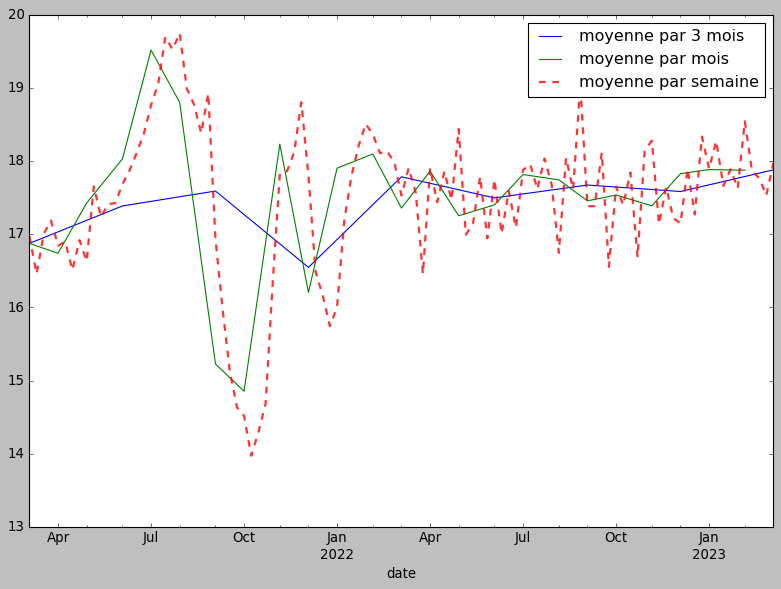

In [24]:
# Je crée une nouvelle data via mon csv ou date sera mon index grace a index_col='date'
df_index_time_final = pd.read_csv("data\Data_clean.csv", index_col='date',parse_dates=True)

figS(12,8)
# J'utilie la fonction resample pour définir ma moyenne sur x temps
df_index_time_final.loc['2021-03-01 16:04:00':'2023-02-28 23:33:12','price'].resample('3M').mean().plot(label='moyenne par 3 mois')
df_index_time_final.loc['2021-03-01 16:04:00':'2023-02-28 23:33:12','price'].resample('M').mean().plot(label='moyenne par mois')
df_index_time_final.loc['2021-03-01 16:04:00':'2023-02-28 23:33:12','price'].resample('W').mean().plot(label='moyenne par semaine', lw=2, ls='--', alpha=0.8)
plt.legend()
# plt.savefig('Variationduprix.png', dpi=300, transparent=True)
plt.show()

## Focus sur le mois d'octobre

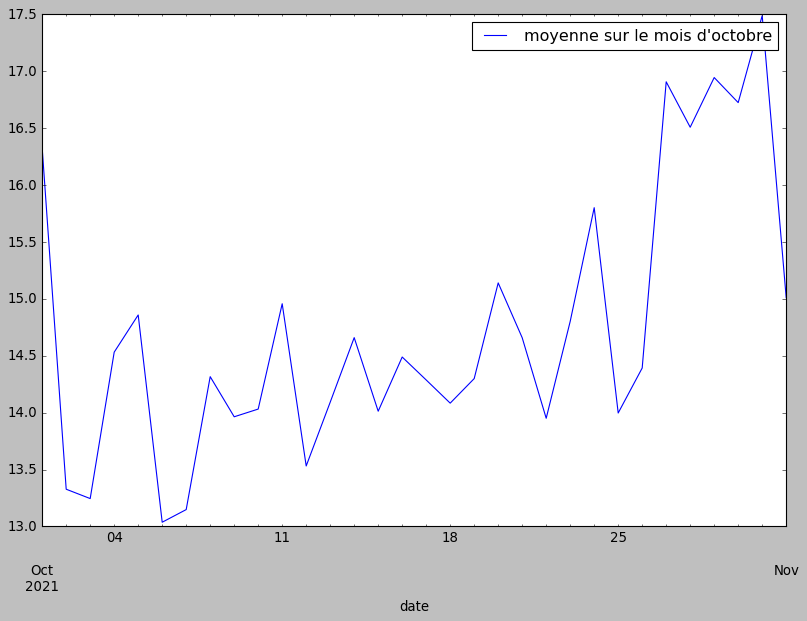

In [25]:
figS(12,8)
# Chute de la moyenne du mois d'octobre
df_index_time_final.loc['2021-10-01 00:00:23':'2021-11-01 00:03:51','price'].resample('d').mean().plot(label='moyenne sur le mois d\'octobre')
plt.legend()
#plt.savefig('Zoomoctobre.png', dpi=300, transparent=True)
plt.show()

### Nombre de ventes mois d'octobre

<AxesSubplot:xlabel='date'>

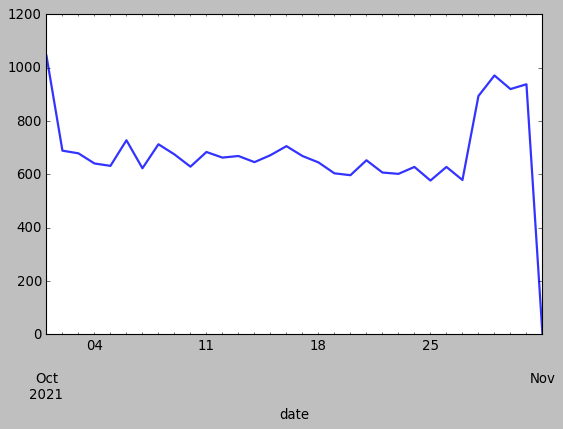

In [26]:
figS(8,5)
# Je regarde le nombre de vente en octobre
df_index_time_final.loc['2021-10-01 00:00:23':'2021-11-01 00:03:51']['id_prod'].resample('d').count().plot(label='moyenne par semaine', lw=2, alpha=0.8)
#plt.savefig('venteoctobre.png', dpi=300, transparent=True)

In [27]:
# Je print le nombre de vente par jour
print(df_index_time_final.loc['2021-10-01 00:00:23':'2021-11-01'].resample('d')['id_prod'].count())

date
2021-10-01    1045
2021-10-02     689
2021-10-03     679
2021-10-04     641
2021-10-05     632
2021-10-06     728
2021-10-07     623
2021-10-08     713
2021-10-09     675
2021-10-10     629
2021-10-11     684
2021-10-12     663
2021-10-13     669
2021-10-14     646
2021-10-15     672
2021-10-16     706
2021-10-17     669
2021-10-18     645
2021-10-19     604
2021-10-20     597
2021-10-21     653
2021-10-22     607
2021-10-23     602
2021-10-24     628
2021-10-25     577
2021-10-26     628
2021-10-27     579
2021-10-28     894
2021-10-29     971
2021-10-30     920
2021-10-31     938
2021-11-01     936
Freq: D, Name: id_prod, dtype: int64


In [28]:
print(df_index_time_final.loc['2021-04-01 00:00:23':'2021-09-01'].resample('d')['id_prod'].count())

date
2021-04-01    915
2021-04-02    961
2021-04-03    948
2021-04-04    886
2021-04-05    983
             ... 
2021-08-28    808
2021-08-29    805
2021-08-30    883
2021-08-31    822
2021-09-01    963
Freq: D, Name: id_prod, Length: 154, dtype: int64


C:\Users\dams_\AppData\Local\Temp/ipykernel_10860/1895135982.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  print(df_index_time_final.loc['2021-04-01 00:00:23':'2021-09-01'].resample('d')['id_prod'].count())


### Nombre de ventes par jour

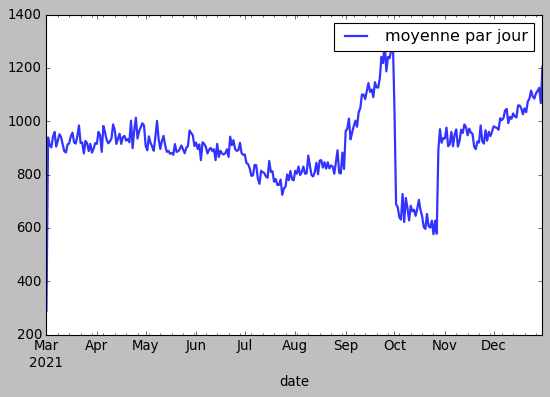

date
2021-03-01     290
2021-03-02     940
2021-03-03     911
2021-03-04     903
2021-03-05     943
              ... 
2021-12-27    1105
2021-12-28    1115
2021-12-29    1126
2021-12-30    1069
2021-12-31    1206
Freq: D, Name: id_prod, Length: 306, dtype: int64


In [29]:
figS(8,5)
# Je regarde les vente par jour
df_index_time_final.loc['2021-03-01 16:04:00':'2022-01-01 00:01:00']['id_prod'].resample('d').count().plot(label='moyenne par jour', lw=2, alpha=0.8)
plt.legend()
#plt.savefig('moyenneoctobre.png', dpi=300, transparent=True)
plt.show()
print(df_index_time_final.loc['2021-03-01 16:04:00':'2022-01-01 00:01:00'].resample('d')['id_prod'].count())

### Catégorie de produits du mois d'octobre

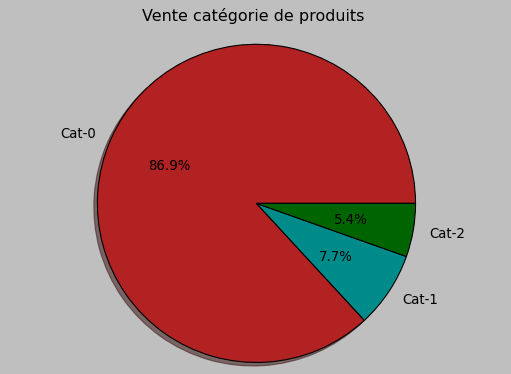

Aprés analyse, la catégorie 0 est la base des vente pour le mois d'octobre


In [30]:
df_check_c_time = df_index_time_final.loc['2021-10-01 00:00:23':'2021-11-01 00:03:51']

df_check_cat0 = df_check_c_time[(df_check_c_time['price'] > 0) & (df_check_c_time['categ'] == 0)]
df_check_cat1 = df_check_c_time[(df_check_c_time['price'] > 0) & (df_check_c_time['categ'] == 1)]
df_check_cat2 = df_check_c_time[(df_check_c_time['price'] > 0) & (df_check_c_time['categ'] == 2)]

# Je crée un camembert pour afficher le % nombre de vente par vente
labels = 'Cat-0','Cat-1','Cat-2'
sizes = [len(df_check_cat0), len(df_check_cat1), len(df_check_cat2)]
colors = ['firebrick','darkcyan','darkgreen']
figS(8,5)
plt.title('Vente catégorie de produits \n')
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
# plt.savefig('categmoisoctobre.png', dpi=300, transparent=True,)
plt.show()

print('Aprés analyse, la catégorie 0 est la base des vente pour le mois d\'octobre')

In [31]:
df_index_time_final.loc['2021-10-01 00:00:23':'2021-11-01 00:03:51']

,id_prod,session_id,client_id,year_month_day,year_buy,Ymonth,sex,birth,price,categ
date,,,,,,,,,,
2021-10-02 17:39:26,0_1409,s_99013,c_5725,2021-10-02,2021,2021-10,m,1975,4.99,0.0
2021-10-03 16:05:12,0_1247,s_99443,c_3394,2021-10-03,2021,2021-10,f,1978,15.99,0.0
2021-10-13 14:35:01,0_1272,s_104207,c_8534,2021-10-13,2021,2021-10,m,1988,17.01,0.0
2021-10-24 13:25:39,0_1102,s_109442,c_1609,2021-10-24,2021,2021-10,m,1980,4.63,0.0
2021-10-05 21:57:27,0_1079,s_100557,c_7918,2021-10-05,2021,2021-10,m,1987,5.99,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-10-22 01:12:51,0_1418,s_108264,c_7213,2021-10-22,2021,2021-10,m,1979,8.57,0.0
2021-10-26 04:40:29,0_1391,s_110243,c_7878,2021-10-26,2021,2021-10,m,1989,7.99,0.0
2021-10-15 16:58:58,0_1609,s_105230,c_6714,2021-10-15,2021,2021-10,f,1968,18.99,0.0


Aprés analyse, je dirais que la chute du CA d'octobre est dû au **achat de valeur moins importante** et à une **legère baisse du nombre de vente**(passant d'une moyenne de **800 à 600**).
Aussi **87%** des ventes du mois d'octobre sont de **catégorie 0**.
Pour moi les données du mois d'octobre ne sont pas a supprimer car malgrer les graph, la baisse du nombre de vente de produit n'est pas aberrante.

In [32]:
df_final_drop_oct = df_final.drop(df_final.index[df_final['Ymonth'] == '2021-10'])
df_final_drop_oct.loc[df_final_drop_oct['Ymonth'] == '2021-10']

,id_prod,date,session_id,client_id,year_month_day,year_buy,Ymonth,sex,birth,price,categ,year_old


In [33]:
df_final_drop_oct.to_csv(r'C:\Users\dams_\PycharmProjects\P6\Data_drop_octobre.csv', index=False, header=True)

## Moyenne mobile

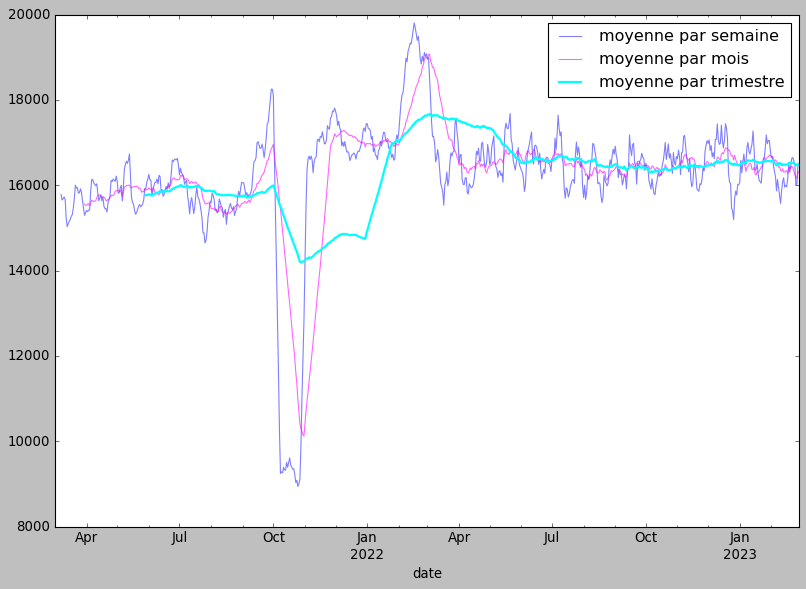

In [34]:
# Je mets ma colonne au farmat date
df_final['date'] = pd.to_datetime(df_final['date'])

# Je créer une variable qui aura un filtre sur les jours
df_period_d = df_final.date.dt.to_period('d')
# Je crée une variable ou j'applique mon filtre via un groupby
df_group = df_final.groupby(df_period_d)
# Puisque ma df est regrouper par jour.Je fait donc le total du prix par jour, ensuite j'applique une moyenne mobile via un rolling(window=X) X=7jours,30jours,90jours..
df_group_d = df_group['price'].sum().rolling(window=7).mean()
df_group_m = df_group['price'].sum().rolling(window=30).mean()
df_group_3m = df_group['price'].sum().rolling(window=90).mean()

figS(12,8)
df_group_d.plot(label='moyenne par semaine', alpha=0.5)
df_group_m.plot(label='moyenne par mois',color='magenta', alpha=0.6)
df_group_3m.plot(label='moyenne par trimestre', lw=2, color='cyan', alpha=1)
plt.legend()
# plt.savefig('moyennemobile.png', dpi=300, transparent=True)
plt.show()

# Produits
Il serait également intéressant de faire un zoom sur les références, pour voir un peu les tops et les
flops, la répartition par catégorie, etc.


In [35]:
# Je check les meilleurs produits
df_bestproduct = df_final.groupby('id_prod')['price'].sum()
df_bestproduct.sort_values(ascending=False).head()

id_prod
2_159    94893.50
2_135    69334.95
2_112    65407.76
2_102    60736.78
2_209    56971.86
Name: price, dtype: float64

## Top et Bot 5 du CA par produit

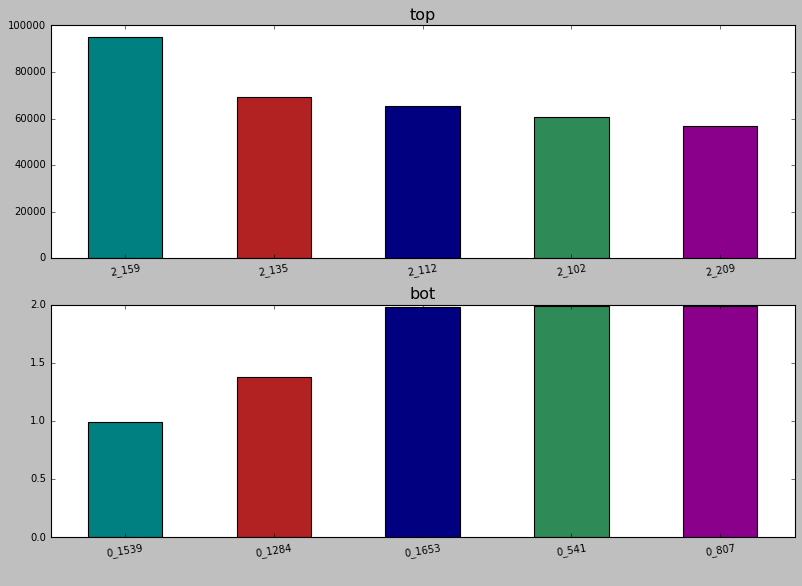

In [36]:
figS(12,8)
# Je crée 2 variable pour contenir le nombre total de mes valeur idprod que je filtre une en croissant et l'autre en décroissant
df_bproduct_sell_asc = df_bestproduct.sort_values(ascending=False)
df_bproduct_sell_desc = df_bestproduct.sort_values(ascending=True)

plt.subplot(211, title='top')
# Je selectionne les 5 premier resultat du top
df_bproduct_sell_asc.iloc[:5].plot(x=df_final['id_prod'], y=df_final.groupby(['price']).sum(),xlabel=' ', kind="bar",color=var_color, rot=9, fontsize=9)

plt.subplot(212, title='bot')
# Je selectionne les 5 dernier resultat du bot
df_bproduct_sell_desc.iloc[:5].plot(x=df_final['id_prod'], y=df_final.groupby(['price']).sum(),xlabel=' ', kind="bar",color=var_color, rot=9, fontsize=9)
# plt.savefig('TopbotprodCA.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

## Top et Bot nombre de vente

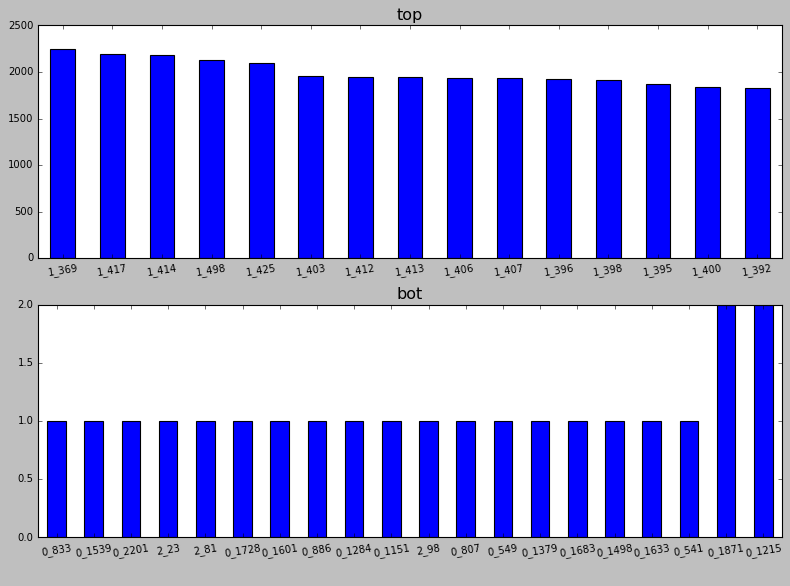

In [37]:
figS(12,8)
# Je crée 2 variable pour contenir le nombre total de mes valeur idprod que je filtre une en croissant et l'autre en décroissant
df_product_sell_asc = df_final['id_prod'].value_counts(ascending=True)
df_product_sell_desc = df_final['id_prod'].value_counts(ascending=False)

plt.subplot(211, title='top')
# Je selectionne les 15 premier resultat du top
df_product_sell_desc.iloc[:15].plot(x=df_final['id_prod'], y=df_final.groupby('id_prod').count(),xlabel=' ', kind="bar", rot=9, fontsize=9)

plt.subplot(212, title='bot')
# Je selectionne les 20 dernier resultat du bot
df_product_sell_asc.iloc[:20].plot(x=df_final['id_prod'], y=df_final.groupby('id_prod').count(),xlabel=' ', kind="bar", rot=9, fontsize=9)
# plt.savefig('Topbotprodvente.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

## Vente par catégorie de produit

### Vente catégorie all time

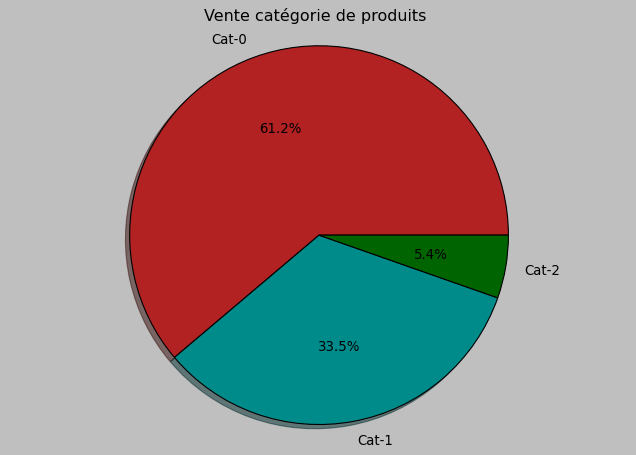

Nombre total de produit par catégorie :
Catégorie 0 : 415,459 
Catégorie 1 : 227,169
Catégorie 2 : 36,483


In [38]:
df_cat_0 = df_final[(df_final['price'] > 0) & (df_final['categ'] == 0)]
df_cat_1 = df_final[(df_final['price'] > 0) & (df_final['categ'] == 1)]
df_cat_2 = df_final[(df_final['price'] > 0) & (df_final['categ'] == 2)]

# Je crée un camembert pour afficher le % nombre de vente par vente
labels = 'Cat-0','Cat-1','Cat-2'
sizes = [len(df_cat_0), len(df_cat_1), len(df_cat_2)]
colors = ['firebrick','darkcyan','darkgreen']
figS(10,6)
plt.title('Vente catégorie de produits \n')
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
# plt.savefig('Ventecatégproduitalltime.png', dpi=300, transparent=True)
plt.show()
# Ici je print le nombre total des mes produit par catégorie pour éxpliquer plus en detail le resultat du plot
print(f"\033[1mNombre total de produit par catégorie :\033[0m\nCatégorie 0 : {len(df_cat_0):,} \nCatégorie 1 : {len(df_cat_1):,}\nCatégorie 2 : {len(df_cat_2):,}")

### Vente catégorie par ans

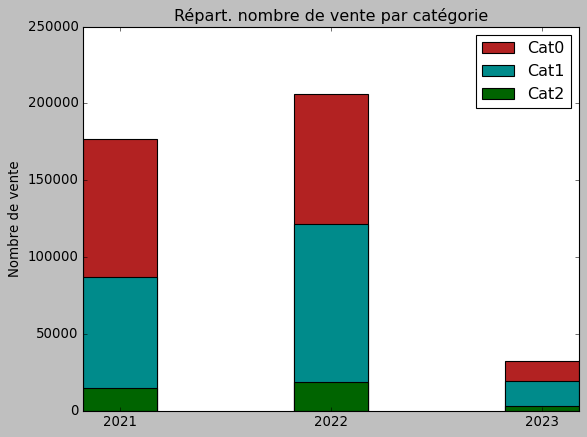

In [39]:
# je créé une fonction pour choisir la date et la catégorie pour m'éviter de devoir re-écrire la formule
def catego(data,date,categ):
    f_cat_0 = data[(data['year_buy'] == date) & (data['price'] > 0) & (data['categ'] == categ)]
    return len(f_cat_0)

labels = ['2021', '2022', '2023']
Categorie0 = [catego(df_final,2021,0), catego(df_final,2022,0), catego(df_final,2023,0)]
Categorie1 = [catego(df_final,2021,1),catego(df_final,2022,1),catego(df_final,2023,1),]
Categorie2 = [catego(df_final,2021,2),catego(df_final,2022,2),catego(df_final,2023,2),]
width = 0.35
fig, ax = plt.subplots()

ax.bar(labels, Categorie0, width,color='firebrick', label='Cat0')
ax.bar(labels, Categorie1, width,color='darkcyan',label='Cat1')
ax.bar(labels, Categorie2, width,color='darkgreen',label='Cat2')

ax.set_ylabel('Nombre de vente')
ax.set_title('Répart. nombre de vente par catégorie')
ax.legend()
# plt.savefig('Répartitionscatégans.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

# Client

## Age H/F/total

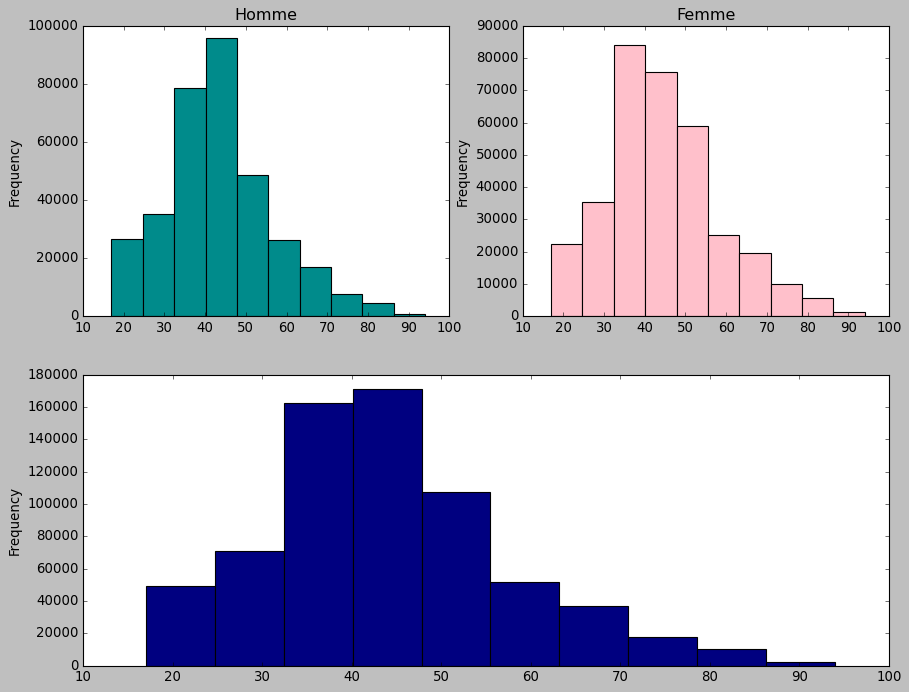

In [40]:
figS(13,10)
plt.subplot(212)
df_final['year_old'].plot(kind='hist', color='navy')
plt.subplot(221, title='Homme')
df_final[df_final['sex']== 'm']['year_old'].plot(kind='hist', color='darkcyan')
plt.subplot(222, title='Femme')
df_final[df_final['sex']== 'f']['year_old'].plot(kind='hist', color='pink')
# plt.savefig('AgeHFTotal.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

## Nombre d'achat H/F

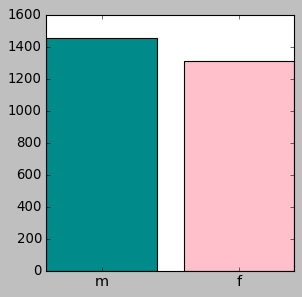

4121 <--  male / female --> 4479
Nombre de clients : 8600 / 8600

Panier moyen (CA total homme / nb client): 1455
Panier moyen (CA total femme / nb client): 1309

Bien qu'il y ait plus de clients feminin, le panier moyen ce trouve etre meilleur chez les clients masculin


In [41]:
# ici je créer 2 df avec le nombre total de client homme et femme
df_client_uni_f = df_final.loc[df_final['sex'] == 'f'].groupby(by='client_id').count()
df_client_uni_m = df_final.loc[df_final['sex'] == 'm'].groupby(by='client_id').count()

df_panier_m_moy = df_ca_m['price'].sum() / len(df_client_uni_m) #1455
df_panier_f_moy = df_ca_f['price'].sum() / len(df_client_uni_f) #1309

figS(4,4)
height = [df_panier_m_moy,df_panier_f_moy]
bars = ('m','f')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height, color=['darkcyan', 'pink'])

# Create names on the x-axis
plt.xticks(y_pos, bars, fontsize=13)
# plt.savefig('HFnombredachat.png', dpi=300, transparent=True,bbox_inches='tight')
# Show graphic
plt.show()

print(len(df_client_uni_m),'<--  male / female -->',len(df_client_uni_f))
print('Nombre de clients :',len(df_client_uni_m) + len(df_client_uni_f),'/', len(df_final.groupby(by='client_id').count()))
print('\nPanier moyen (CA total homme / nb client):',round(df_panier_m_moy))
print('Panier moyen (CA total femme / nb client):',round(df_panier_f_moy))
print('\033[1m\nBien qu\'il y ait plus de clients feminin, le panier moyen ce trouve etre meilleur chez les clients masculin\033[0m')

## Courbe de lorenz client / prix

0.45


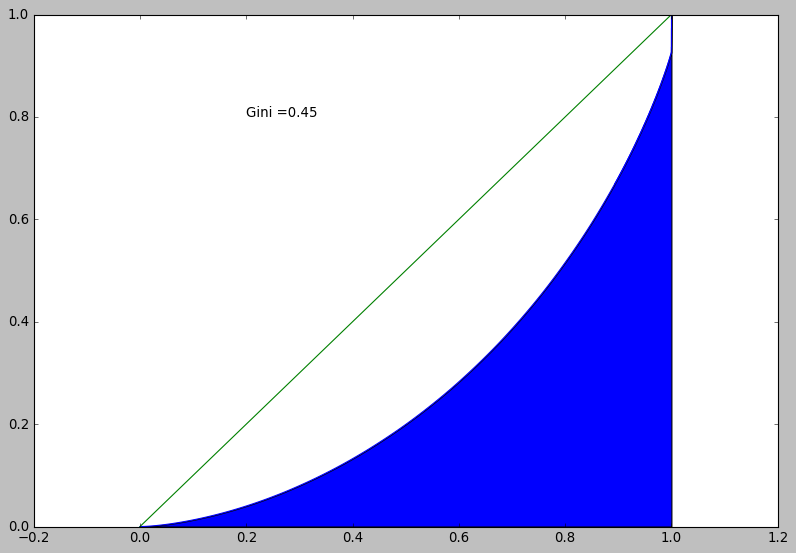

In [42]:
# je fait le chiffre d'affaires de chacun de mes client
df_ca_client = df_final.groupby(by='client_id')['price'].sum()
df_ca_client = df_ca_client.reset_index()
courbe_lorenz(df_ca_client, 'price')
# Il varie entre 0 (égalité parfaite) et 1 (inégalité extrême).

# Corrélation

## lien entre le genre d’un client et les catégories

In [43]:
# Alors ici je regroupe par sex et catégorie et je fait le CA
df_gender_cat_sum = df_final[['client_id','sex','categ','price','id_prod']]
df_gender_cat_sum = df_gender_cat_sum.groupby(by=['sex','categ'])['price'].sum().reset_index()
# Je drop mes ligne 3 et 7 qui correspondent a mes catégorie inconnu(99)
df_gender_cat_sum.drop([3, 7],inplace=True)
df_gender_cat_sum.head(500)

,sex,categ,price
0,f,0.0,2190013.07
1,f,1.0,2358417.02
2,f,2.0,1311253.04
4,m,0.0,2229717.90
5,m,1.0,2295305.67
6,m,2.0,1469021.98


In [44]:
# Alors ici je regroupe par sex et catégorie et je fait le moyenne du CA
df_gender_cat_mean = df_final[['client_id','sex','categ','price','id_prod']].copy()
df_gender_cat_mean['panier moyen'] = (df_gender_cat_mean['price'] / len(df_gender_cat_mean['client_id'])).astype(object)
df_gender_cat_mean = df_gender_cat_mean.groupby(by=['sex','categ','panier moyen'])['price'].sum().reset_index()
# # Je drop mes ligne 3 et 7 qui correspondent a mes catégorie inconnu(99)
df_gender_cat_mean.drop([3, 7],inplace=True)
df_gender_cat_mean.head(500)

,sex,categ,panier moyen,price
0,f,0.0,9.126613e-07,6.82
1,f,0.0,9.715426e-07,3.96
2,f,0.0,1.133466e-06,0.77
4,f,0.0,1.295390e-06,2.64
5,f,0.0,1.354272e-06,2.76
...,...,...,...,...
497,f,0.0,1.764969e-05,81244.24
498,f,0.0,1.769385e-05,204.34
499,f,0.0,1.770857e-05,6171.39
500,f,0.0,1.772329e-05,144.48


In [45]:
# ici je regroupe par sex et catégorie et je fait le moyenne du CA
df_gender_cat_mean = df_final[['client_id','sex','categ','price','id_prod']]
df_gender_cat_mean = df_gender_cat_mean.groupby(by=['sex','categ'])['price'].mean().reset_index()
# Je drop mes ligne 3 et 7 qui correspondent a mes catégorie inconnu(99)
df_gender_cat_mean.drop([3, 7],inplace=True)
df_gender_cat_mean.head(500)

,sex,categ,price
0,f,0.0,10.625818
1,f,1.0,20.526001
2,f,2.0,75.869527
4,m,0.0,10.650365
5,m,1.0,20.444515
6,m,2.0,76.511561


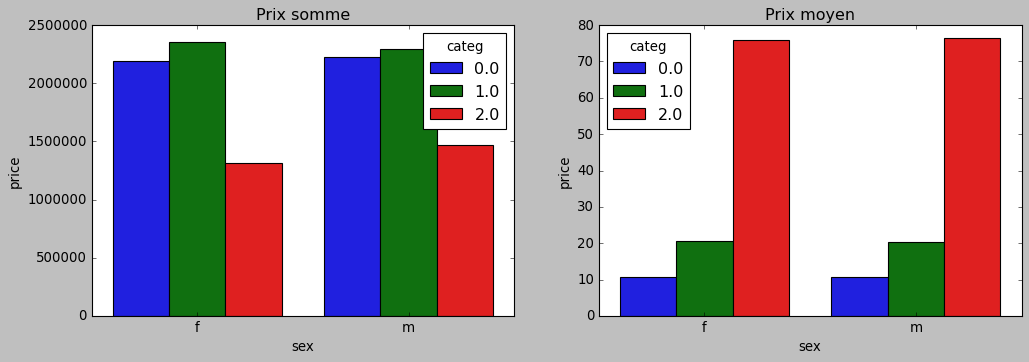

In [83]:
figS(15,10)
plt.subplot(221, title='Prix somme')
sns.barplot(y='price',x='sex',hue='categ',data=df_gender_cat_sum)
plt.subplot(222, title='Prix moyen')
sns.barplot(y='price',x='sex',hue='categ',data=df_gender_cat_mean)
# plt.savefig('CorrSexCateg.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

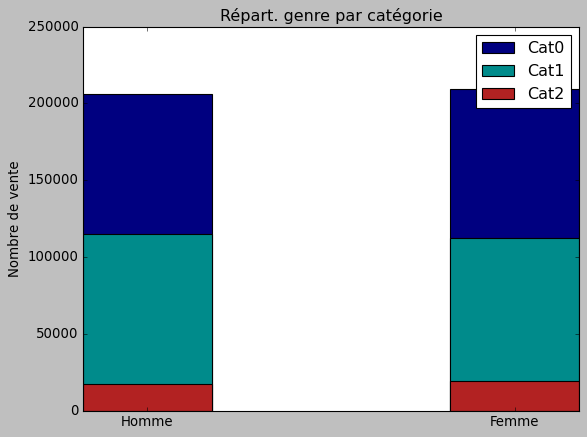

In [47]:
labels = ['Homme', 'Femme']
Categorie0 = [cat_gender(df_final,'f',0), cat_gender(df_final,'m',0)]
Categorie1 = [cat_gender(df_final,'f',1),cat_gender(df_final,'m',1)]
Categorie2 = [cat_gender(df_final,'f',2),cat_gender(df_final,'m',2)]
width = 0.35
fig, ax = plt.subplots()

ax.bar(labels, Categorie0, width,color='navy', label='Cat0')
ax.bar(labels, Categorie1, width,color='darkcyan',label='Cat1')
ax.bar(labels, Categorie2, width,color='firebrick',label='Cat2')

ax.set_ylabel('Nombre de vente')
ax.set_title('Répart. genre par catégorie')
ax.legend()

plt.show()


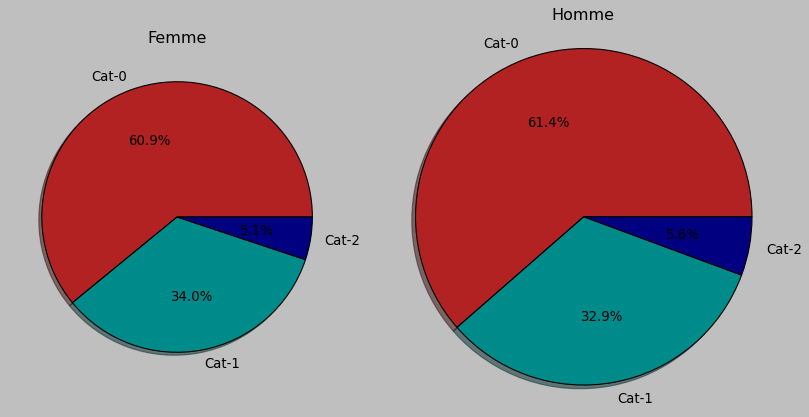

In [48]:
figS(12,6)
# Je crée un camembert pour afficher le % nombre de vente par vente
labels = 'Cat-0','Cat-1','Cat-2'
sizef = [cat_gender(df_final,'f',0), cat_gender(df_final,'f',1), cat_gender(df_final,'f',2)]
sizem = [cat_gender(df_final,'m',0), cat_gender(df_final,'m',1), cat_gender(df_final,'m',2)]
colors = ['firebrick','darkcyan','navy']

plt.subplot(121,title='Femme')
plt.pie(sizef, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)

plt.subplot(122,title='Homme')
plt.pie(sizem, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')

plt.show()

### Corrélation genre Catégorie

H0: Il n'y a pas de liens entre la catégorie de livre acheter et le sex du clients
H1: Il y a un liens entre la catégorie de livre acheter et le sex du client
% d'erreur 5% = Table 3,841

In [49]:
df_final.groupby('client_id').sum()

,year_buy,birth,price,categ,year_old
client_id,,,,,
c_1,78841,76245,558.18,10.0,2596
c_10,117253,113448,1353.60,42.0,3805
c_100,16170,15936,254.85,7.0,234
c_1000,252715,245750,2261.89,82.0,6965
c_1001,206205,202164,1812.86,33.0,4041
...,...,...,...,...,...
c_995,28300,27370,189.41,3.0,930
c_996,192058,187150,1625.58,55.0,4908
c_997,119284,117646,1490.01,51.0,1638


In [50]:
# je crée un copy de mon df_dinal ou je retire la categ 99
df_drop_categ_99 = df_final.copy()
df_drop_categ_99.drop(df_drop_categ_99.index[df_drop_categ_99['categ'] == 99.0], inplace=True)

# Ici je drop mes 4 plus gros clients
# df_drop_categ_99.drop(df_drop_categ_99.index[(df_drop_categ_99['client_id'] == 'c_1609') | (df_drop_categ_99['client_id'] == 'c_4958') | (df_drop_categ_99['client_id'] == 'c_6714') | (df_drop_categ_99['client_id'] == 'c_3454')] , inplace=True)

df_test = df_drop_categ_99.groupby(['categ','sex']).sum().reset_index()
df_test = df_test[['categ','sex','price']]
# Je crée ma table avec margins=True pour avoir le total de chaque lignes et colonnes
var_calcul = pd.crosstab(df_drop_categ_99['sex'],df_drop_categ_99['categ'])
var_calcul

categ,0.0,1.0,2.0
sex,,,
f,206103,114899,17283
m,209356,112270,19200


**La somme total d'homme est de : 340,826
La somme total de femme est de : 338,285
La somme total de la catégorie 0 est de : 415,459
La somme total de la catégorie 1 est de : 227,169
La somme total de la catégorie 2 est de : 36,483**

In [51]:
# Je crée ma table normaliser
df_sex_categ = pd.crosstab(df_drop_categ_99['sex'],df_drop_categ_99['categ'],normalize=True)
df_sex_categ

categ,0.0,1.0,2.0
sex,,,
f,0.303489,0.169190,0.025449
m,0.308280,0.165319,0.028272


In [52]:
# (147.11906816131497, 2, 1.1310980597090762e-32) (0.0002166347889539628, 2, 0.9998916884716402) sans le drop client
# (20.213460693513895, 2, 4.080400389217356e-05) (3.195920277498468e-05, 2, 0.9999840205262857) avec le drop client
stats.chi2_contingency(df_sex_categ)

(0.0002166347889539628,
 0.9998916884716402,
 2,
 array([[0.30473994, 0.16662888, 0.02676035],
        [0.30702897, 0.1678805 , 0.02696136]]))

pvalues = 0,999 > a = 0,05
Donc je valide l'h0, il n'y a pas de liens entre la catégorie de livre acheter et le sexe du client

5% = 5,9915 ( Mon resultat d'hypothese rejeter si mon test chi-2 est inferieur ou superieur ?( Valider si inferieur ou superieur ?)

## Age clients et montant total des achats

In [53]:
# je check mes colonne cleint age.
df_final.groupby(['client_id','year_old'])['price'].sum()

client_id  year_old
c_1        66           294.66
           67           219.23
           68            44.29
c_10       65           586.18
           66           602.93
                        ...   
c_998      21          1179.06
           22           498.96
c_999      57           226.60
           58           394.11
           59            80.69
Name: price, Length: 24186, dtype: float64

In [54]:
# Cette formule est bien si je dois trouver le lien entre age et montant total achat de client precis
# df_yo_ca = df_yo_ca.groupby(['client_id']).agg({'price':np.sum, 'year_old':np.mean}).reset_index()


# Je crée ma df ou je regoupe pas Age et je fait la sum()
df_yo_ca = df_final.groupby('year_old').sum().reset_index() # cette formule est mieux car je prend just l'age auquelle j'ajoute le prix total

# j'arrondi valeur au dessus
df_yo_ca['year_old'] = df_yo_ca['year_old'].round()
df_yo_ca['price'] = df_yo_ca['price'].round()

df_yo_ca.head()

,year_old,year_buy,birth,price,categ
0,17,11994635,11893740,241266.0,6920.0
1,18,19482207,19308759,384592.0,11315.0
2,19,10936527,10833756,221918.0,6568.0
3,20,8960214,8871574,177140.0,5396.0
4,21,8705348,8614922,172109.0,5031.0


In [55]:
# je check mes valeur price et age.
df_yo_ca.sort_values(by='price',ascending=False)
# df_yo_ca.sort_values(by='year_old',ascending=False)

,year_old,year_buy,birth,price,categ
25,42,71957956,70463092,468753.0,9259.0
24,41,62344294,61079772,399490.0,7286.0
1,18,19482207,19308759,384592.0,11315.0
26,43,53532085,52393531,352206.0,8123.0
6,23,15288802,15114876,347552.0,10193.0
...,...,...,...,...,...
73,90,491303,469433,4114.0,152.0
74,91,424559,405449,3455.0,117.0
75,92,396263,378231,3310.0,130.0
76,93,260852,248855,2116.0,88.0


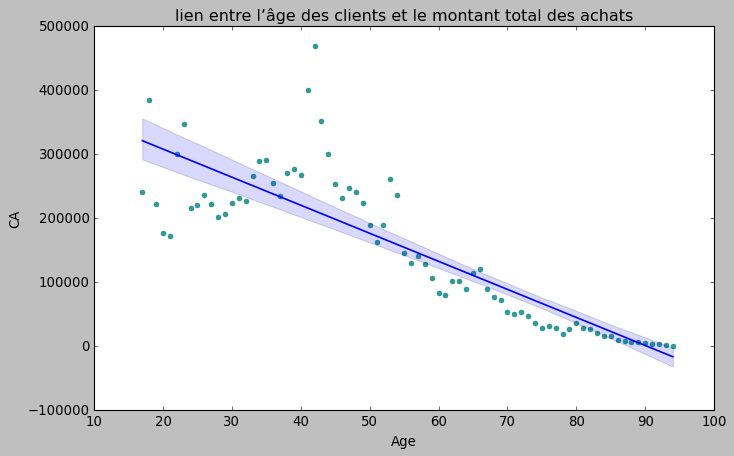

             price  year_old
price     1.000000 -0.856639
year_old -0.856639  1.000000

In [82]:
figS(10,6)
sns.regplot(y=df_yo_ca['price'], x=df_yo_ca['year_old'],scatter_kws={'color':'teal'})
plt.title('lien entre l’âge des clients et le montant total des achats')
plt.ylabel('CA')
plt.xlabel('Age')
# plt.savefig('CorrAgeAchat.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

# print de ma correlation prix age
print(df_yo_ca[['price','year_old']].corr(), end='')

In [57]:
#Test de corrélation de pearson
corr, _ = pearsonr(df_yo_ca['price'], df_yo_ca['year_old'])
print('Pearsons correlation: %.4f' % corr)

Pearsons correlation: -0.8566


Donc le test de corrélation de peasrons prend 0 quand il n'y a pas de liens.
Donc avec -0.8566 j'ai une forte relation négative.
Donc pour moi cela serait plus l'age augmente plus les prix baisse.

H0 : le montant total des achat n'a pas de lien avec l'age du client
H1 : le montant total des achat a un lien avec l'age du client

## Age client et fréquense d'achat

In [58]:
#Je pars du principe qu'une session aboutie a une vente
#Donc je crée ma variable qui regoupe l'age de tout mes clients et je compte combien de session par age
df_client_achat = df_final.groupby('year_old').count().reset_index()
df_client_achat = df_client_achat[['year_old', 'session_id']]

#Fréquence d’achat = Nombre total de commandes / Nombre de clients uniques
#Ex: Age 94 = Total session 23 / Total session.sum()
df_client_achat['frequence'] = df_client_achat['session_id']/df_client_achat['session_id'].sum()
df_client_achat.sort_values(by='year_old', ascending=False).head()

,year_old,session_id,frequence
77,94,23,0.000034
76,93,129,0.000190
75,92,196,0.000289
74,91,210,0.000309
73,90,243,0.000358


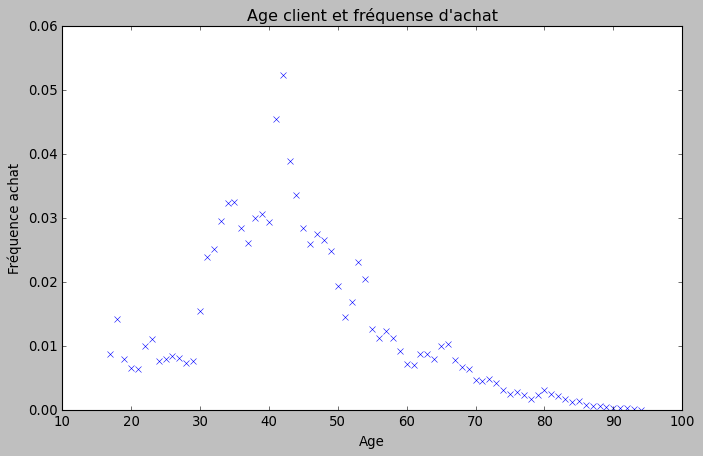

In [59]:
figS(10,6)
plt.plot(df_client_achat['year_old'], df_client_achat['frequence'], 'x')
plt.ylabel('Fréquence achat')
plt.xlabel('Age')
plt.title('Age client et fréquense d\'achat')
plt.show()

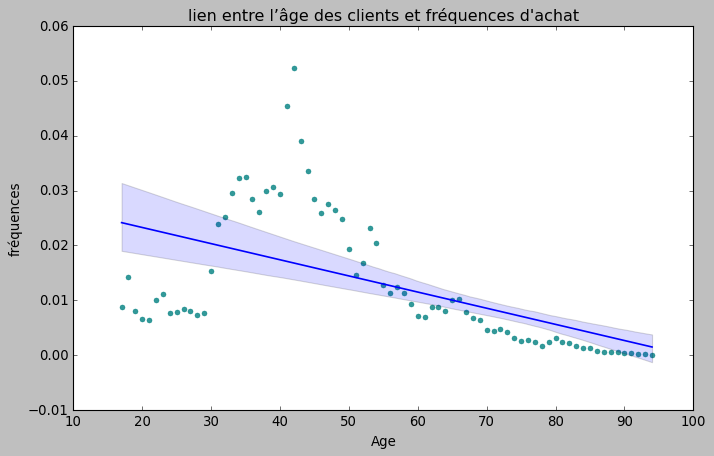

           frequence  year_old
frequence   1.000000 -0.555359
year_old   -0.555359  1.000000

In [84]:
figS(10,6)
sns.regplot(y=df_client_achat['frequence'], x=df_client_achat['year_old'],scatter_kws={'color':'teal'})
plt.title('lien entre l’âge des clients et fréquences d\'achat')
plt.ylabel('fréquences')
plt.xlabel('Age')
# plt.savefig('CorrFreqAchat.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()
#print de ma correlation
print(df_client_achat[['frequence','year_old']].corr(), end='')

In [61]:
corr, _ = pearsonr(df_client_achat['year_old'], df_client_achat['frequence'])
print('Pearsons correlation: %.4f' % corr)

Pearsons correlation: -0.5554


Donc le test de corrélation de peasrons prend 0 quand il n'y a pas de liens.
Donc avec -0.5554 j'ai une relation négative.
Donc pour moi oui il y a un lien entre l'age du client et la frequence d'achat

H0 : il n'y a pas de lien entre l'age du client et la frequence d'achat
H1 : il y a un lien entre l'age du client et la frequence d'achat

## Age client et panier moyen

pour la taille du panier moyen, comme il était écrit "taille", j'ai pris le nombre d'articles.

In [62]:
#Donc je crée ma variable que je regroupre par age et session(pour avoir mes articles unique) et je fais un count() pour avoir mes infos article
df_client_pm = df_final.groupby(['year_old', 'session_id']).count().reset_index()
#sum price

#Puis je regroupe par age et je fait la moyenne d'article
df_client_pm = df_client_pm.groupby('year_old').mean().reset_index()
df_client_pm = df_client_pm[['year_old', 'id_prod']]
df_client_pm.head()

,year_old,id_prod
0,17,1.743025
1,18,1.758073
2,19,1.735322
3,20,1.761526
4,21,1.768378


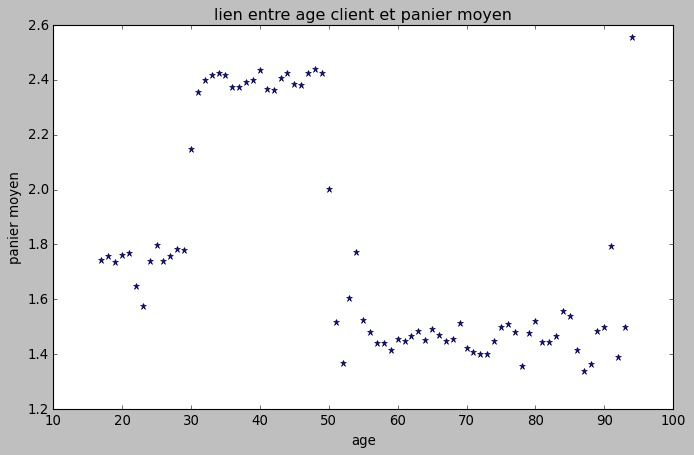

In [63]:
figS(10,6)
plt.plot(df_client_pm['year_old'], df_client_pm['id_prod'], '*')
plt.ylabel('panier moyen')
plt.xlabel('age')
plt.title('lien entre age client et panier moyen')
plt.show()

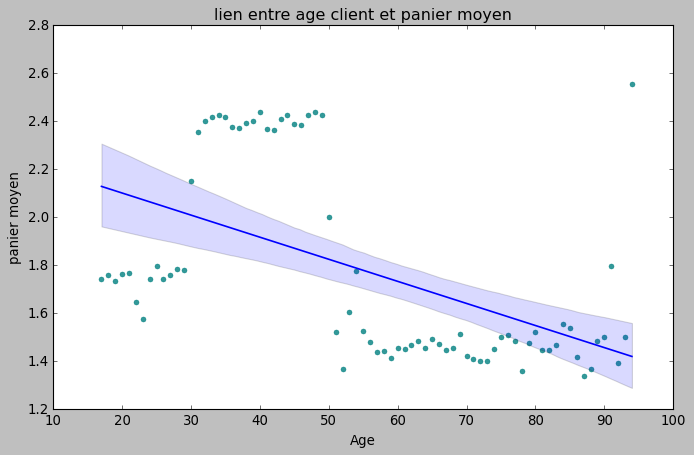

           id_prod  year_old
id_prod   1.000000 -0.517347
year_old -0.517347  1.000000

In [86]:
figS(10,6)
sns.regplot(y=df_client_pm['id_prod'], x=df_client_pm['year_old'],scatter_kws={'color':'teal'})
plt.title('lien entre age client et panier moyen')
plt.ylabel('panier moyen')
plt.xlabel('Age')
# plt.savefig('CorrPaniermoyerAge.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()
#print de ma correlation
print(df_client_pm[['id_prod','year_old']].corr(), end='')

In [65]:
corr, _ = pearsonr(df_client_pm['year_old'], df_client_pm['id_prod'])
print('Pearsons correlation: %.4f' % corr)

Pearsons correlation: -0.5173


Donc le test de corrélation de peasrons prend 0 quand il n'y a pas de liens.
Donc avec -0.517347 j'ai une relation négative.
Donc pour moi oui il y a un lien entre certainne catégorie d'age et le panier moyen (18-30ans , 30-50ans , 50~90+ans)

H0 : il n'y a pas de lien entre l'age du client et le panier moyen
H1 : il y a un lien entre l'age du client et le panier moyen

## Age et catégorie des livres achetés

In [66]:
# Vue sur le discord repris pour la culture mais en aucun cas de mon fait
for i in df_final.sort_values('year_old')['year_old'].unique():
    df= df_final.loc[df_final['year_old'] == i]
    fit = statsmodels.formula.api.ols('year_old ~ categ',data = df).fit()
    table = statsmodels.api.stats.anova_lm(fit)
    table['H0']= table['PR(>F)'] > 0.05
    print('pour les personnes agées de',i,'ans, H0 est ',table.iloc[0][5])

pour les personnes agées de 17 ans, H0 est  True
pour les personnes agées de 18 ans, H0 est  False
pour les personnes agées de 19 ans, H0 est  True
pour les personnes agées de 20 ans, H0 est  False
pour les personnes agées de 21 ans, H0 est  False
pour les personnes agées de 22 ans, H0 est  False
pour les personnes agées de 23 ans, H0 est  True
pour les personnes agées de 24 ans, H0 est  False
pour les personnes agées de 25 ans, H0 est  False
pour les personnes agées de 26 ans, H0 est  True
pour les personnes agées de 27 ans, H0 est  True
pour les personnes agées de 28 ans, H0 est  False
pour les personnes agées de 29 ans, H0 est  True
pour les personnes agées de 30 ans, H0 est  True
pour les personnes agées de 31 ans, H0 est  False
pour les personnes agées de 32 ans, H0 est  True
pour les personnes agées de 33 ans, H0 est  False
pour les personnes agées de 34 ans, H0 est  False
pour les personnes agées de 35 ans, H0 est  False
pour les personnes agées de 36 ans, H0 est  True
pour les 

In [67]:
# ici je vais chercher ma dataframe ou la categ 99 a était drop. Puis je regoupe par age et caté et je compte le nombre de session car comme plus tot une session = un achat
df_year_categ = df_drop_categ_99.groupby(['year_old', 'categ']).count().reset_index()
df_year_categ = df_year_categ[['year_old', 'categ', 'session_id']]
df_year_categ.head()

,year_old,categ,session_id
0,17,0.0,1400
1,17,1.0,2150
2,17,2.0,2385
3,18,0.0,2118
4,18,1.0,3721


<a href="https://medium.com/analytics-vidhya/customer-demographics-segmentation-analysis-with-simple-python-cdd2e6d35f2e">Médium pour le split d'age</a>

In [68]:
# ici j'utilise cut() ou je split mes catégorie par parametre bins( tranche d'age que j'ai utiliser plus tot dans mon chiffre d'affaires)
df_year_categ['year_old']= pd.cut(df_year_categ['year_old'], bins = [18,25,35,45,55,70,80,90,150], labels= ['18-25','26-35','36-45','46-55','56-70','71-80','81-90','90+'])
# Je regroupe par age et categ puis je fait la somme de mes sesssion
df_year_categ = df_year_categ.groupby(['year_old','categ']).sum().reset_index()
df_year_categ.head(500)

,year_old,categ,session_id
0,18-25,0.0,7738
1,18-25,1.0,14543
2,18-25,2.0,16816
3,26-35,0.0,85270
4,26-35,1.0,33330
5,26-35,2.0,10594
6,36-45,0.0,177748
7,36-45,1.0,54711
8,36-45,2.0,759
9,46-55,0.0,89967


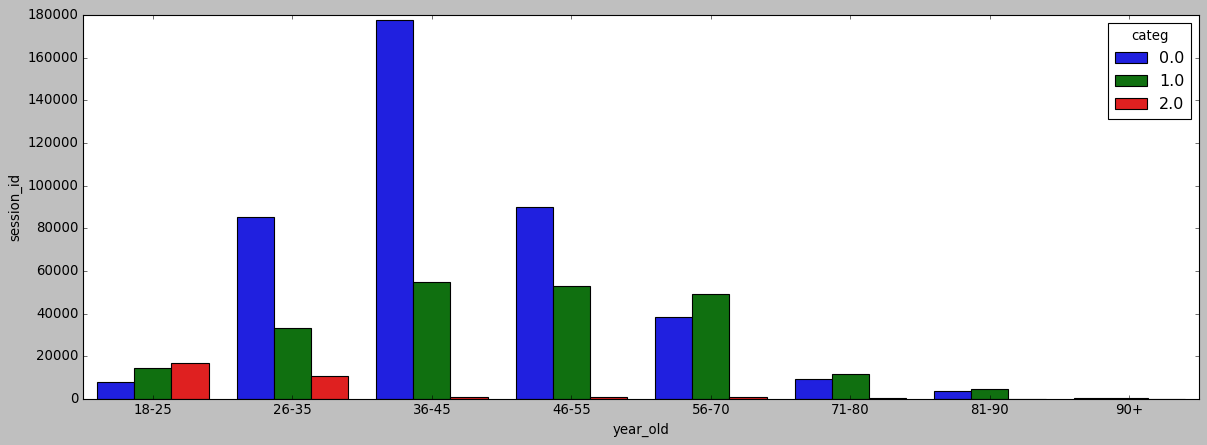

In [87]:
figS(18,6)
sns.barplot(x='year_old', y='session_id',hue='categ', data=df_year_categ)
ax.set_title('Distribution of Spending Score by Age Group')
plt.savefig('CorrAgeCatégo.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

In [70]:
# Méthod ANOVA pour les valeur qualitative x quantitative
X = "year_old" # qualitative
Y = "session_id" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

eta_squared(df_year_categ['year_old'],df_year_categ['session_id'])

0.3849147262161766

In [71]:
from scipy import stats as mystats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
mymodel=ols('session_id ~ year_old',df_year_categ).fit()
anova_table=anova_lm(mymodel)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
year_old,7.0,1.551569e+10,2.216526e+09,1.430379,0.260478
Residual,16.0,2.479372e+10,1.549608e+09,NaN,NaN


# Total d'achat client & client/catégorie

Age moyen des Femmes 44 ans 
Age moyen des Hommes 43 ans

Age médian des Femmes 43 ans 
Age médian des Hommes 42 ans



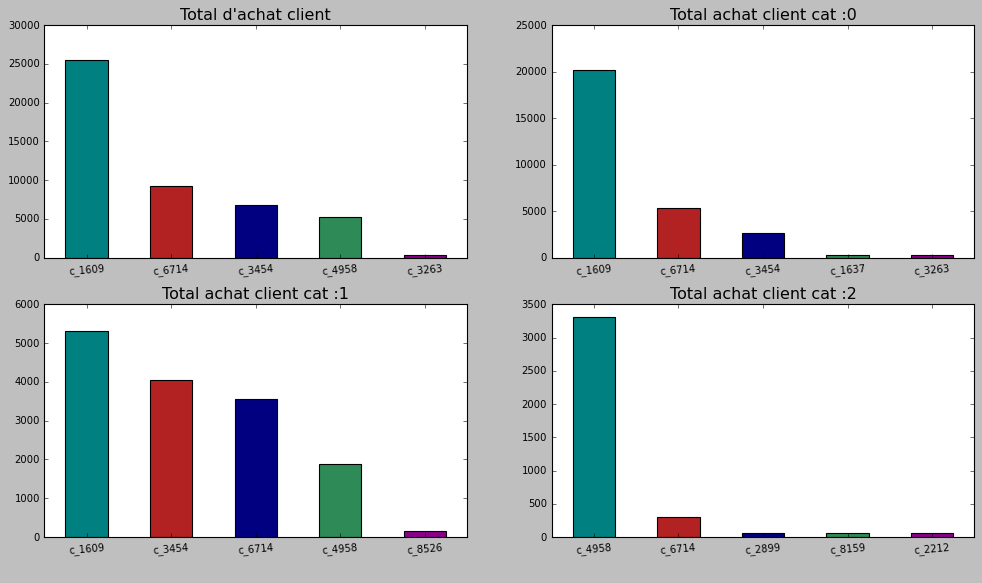

In [72]:
print("Age moyen des Femmes",round(df_final[(df_final['sex'] == 'f')]['year_old'].mean()),'ans',"\nAge moyen des Hommes",round(df_final[(df_final['sex'] == 'm')]['year_old'].mean()),'ans', end='\n\n')
print("Age médian des Femmes",round(df_final[(df_final['sex'] == 'f')]['year_old'].median()),'ans',"\nAge médian des Hommes",round(df_final[(df_final['sex'] == 'm')]['year_old'].median()),'ans' ,end='\n\n')

df_client_buy = df_final['client_id'].value_counts(ascending=False)
df_client_buy_cat0 = df_final[df_final['categ'] == 0].value_counts('client_id',ascending=False)
df_client_buy_cat1 = df_final[df_final['categ'] == 1].value_counts('client_id',ascending=False)
df_client_buy_cat2 = df_final[df_final['categ'] == 2].value_counts('client_id',ascending=False)

plt.figure(figsize=(15,8))
plt.subplot(221,title='Total d\'achat client')
df_client_buy.iloc[:5].plot(x=df_final['client_id'], y=df_final.groupby('client_id').count(), kind="bar",color=var_color, rot=5, fontsize=9)

plt.subplot(222,title='Total achat client cat :0')
df_client_buy_cat0.iloc[:5].plot(x=df_final['client_id'], y=df_final.groupby('client_id').count(),xlabel=' ', kind="bar",color=var_color, rot=5, fontsize=9)

plt.subplot(223,title='Total achat client cat :1')
df_client_buy_cat1.iloc[:5].plot(x=df_final['client_id'], y=df_final.groupby('client_id').count(),xlabel=' ', kind="bar",color=var_color, rot=5, fontsize=9)

plt.subplot(224,title='Total achat client cat :2')
df_client_buy_cat2.iloc[:5].plot(x=df_final['client_id'], y=df_final.groupby('client_id').count(),xlabel=' ', kind="bar",color=var_color, rot=5, fontsize=9)
# plt.savefig('Clientotalcat.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

<AxesSubplot:title={'center':'Total achat client cat :2'}, xlabel=' '>

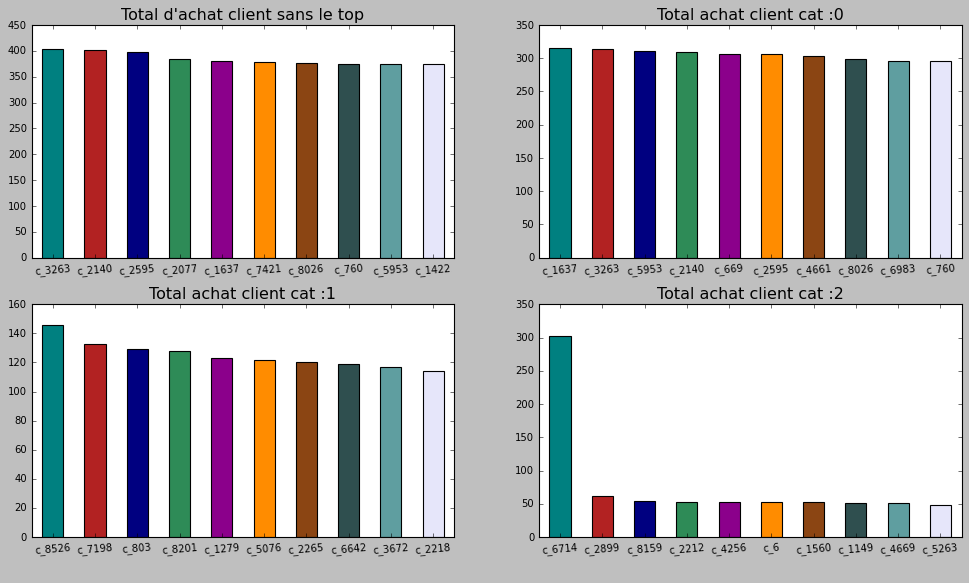

In [73]:
# Ici je retire les top client des plot précédent
plt.figure(figsize=(15,8))
plt.subplot(221,title='Total d\'achat client sans le top')
df_client_buy.iloc[4:14].plot(x=df_final['sex'], y=df_final.groupby('sex').count(), kind="bar",color=var_color, rot=5, fontsize=9)

plt.subplot(222,title='Total achat client cat :0')
df_client_buy_cat0.iloc[3:13].plot(x=df_final['client_id'], y=df_final.groupby('client_id').count(),xlabel=' ', kind="bar",color=var_color, rot=5, fontsize=9)

plt.subplot(223,title='Total achat client cat :1')
df_client_buy_cat1.iloc[4:14].plot(x=df_final['client_id'], y=df_final.groupby('client_id').count(),xlabel=' ', kind="bar",color=var_color, rot=5, fontsize=9)

plt.subplot(224,title='Total achat client cat :2')
df_client_buy_cat2.iloc[1:11].plot(x=df_final['client_id'], y=df_final.groupby('client_id').count(),xlabel=' ', kind="bar",color=var_color, rot=5, fontsize=9)
# plt.savefig('topclientsansgros.png', dpi=300, transparent=True,bbox_inches='tight')

In [74]:
# minnimum transaction par un client '1' et maximum 25488
df_client_buy.describe()

count     8600.000000
mean        78.992093
std        312.437204
min          1.000000
25%         27.000000
50%         51.000000
75%         96.000000
max      25488.000000
Name: client_id, dtype: float64

# Corrélations

In [75]:
df_final.corr()

,year_buy,birth,price,categ,year_old
year_buy,1.000000,-0.002629,0.014199,0.010610,0.048067
birth,-0.002629,1.000000,0.209443,0.031462,-0.998967
price,0.014199,0.209443,1.000000,0.213230,-0.208557
categ,0.010610,0.031462,0.213230,1.000000,-0.030944
year_old,0.048067,-0.998967,-0.208557,-0.030944,1.000000


In [76]:
df_final.corr(method='kendall')

C:\Users\dams_\anaconda3\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


,year_buy,birth,price,categ,year_old
year_buy,1.000000,-0.002182,0.019812,0.036323,0.042900
birth,-0.002182,1.000000,0.033523,0.022518,-0.982961
price,0.019812,0.033523,1.000000,0.573708,-0.032831
categ,0.036323,0.022518,0.573708,1.000000,-0.021238
year_old,0.042900,-0.982961,-0.032831,-0.021238,1.000000


In [77]:
df_final.corr(method='spearman')

,year_buy,birth,price,categ,year_old
year_buy,1.000000,-0.002716,0.024880,0.038280,0.053389
birth,-0.002716,1.000000,0.054897,0.036637,-0.998317
price,0.024880,0.054897,1.000000,0.686270,-0.053926
categ,0.038280,0.036637,0.686270,1.000000,-0.035107
year_old,0.053389,-0.998317,-0.053926,-0.035107,1.000000


Text(0.5, 1.0, 'Correlation')

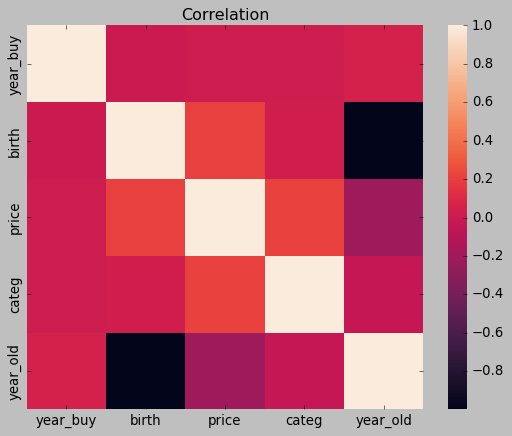

In [78]:
sns.heatmap(df_final.corr()).set_title('Correlation')
# plt.savefig('heatmapcorr.png', dpi=300, transparent=True,bbox_inches='tight')

In [79]:
def correlations(data):
    plt.figure(figsize=(12,8))
    mask = np.triu(np.ones_like(data.corr(), dtype=bool))
    sns.heatmap(data.corr(),mask=mask,center=0,cmap='RdBu',linewidths=1, annot=True, fmt='.2f', vmin=-1, vmax=1).set_title('Correlation')
    plt.title('Corrélation')
    # plt.savefig('heatcorr.png', dpi=300, transparent=True,bbox_inches='tight')
    plt.show()

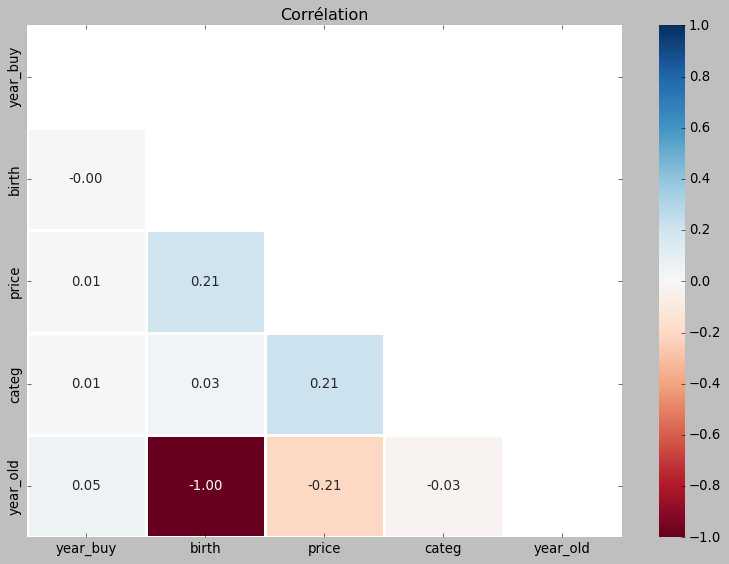

In [80]:
correlations(df_final)